In [4]:
from astropy.coordinates import SkyCoord, HeliocentricMeanEcliptic, BarycentricMeanEcliptic, BarycentricTrueEcliptic
from astropy.coordinates import get_body_barycentric
from astropy.time import Time
from astroquery.jplhorizons import Horizons

import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt

def get_parallax_vector(t_in_days):
    earth = Horizons(id='399', 
                   location='500@0',
                   epochs=2451545.0)
    obj = Horizons(id="90377;",
                   location="500@0",
                   epochs=2451545.0)

    vx,vy,vz = earth.vectors()['vx'],earth.vectors()['vy'],earth.vectors()['vz']
    x,y,z = obj.vectors()['x'],obj.vectors()['y'],obj.vectors()['z'] 
    x_0 = np.array([x,y,z])
    v = np.array([vx,vy,vz])
    parallax = x_0 + v * t_in_days
    # parallax points in the opposite direction of the velocity
    return -1 * parallax
    

In [ ]:
from numpy import radians, sin, cos
RA_CENTER_IDX = 512
DEC_CENTER_IDX = 512
DEG_PER_PIXEL = 0.25 / 3600
from tqdm import tqdm

import numpy as np

def to_rotation_matrix(inclination, ascending_node, argument_of_periapsis):
    # Calculate trigonometric values
    cos_i = np.cos(inclination)
    sin_i = np.sin(inclination)
    cos_o = np.cos(ascending_node)
    sin_o = np.sin(ascending_node)
    cos_p = np.cos(argument_of_periapsis)
    sin_p = np.sin(argument_of_periapsis)
    
    # Ecliptic tilt (Earth's axial tilt)

    
    # Define the rotation matrices
    inclination_matrix = np.array([
        [1.0, 0.0, 0.0],
        [0.0, cos_i, -sin_i],
        [0.0, sin_i, cos_i]
    ])

    ascending_node_matrix = np.array([
        [cos_o, -sin_o, 0.0],
        [sin_o, cos_o, 0.0],
        [0.0, 0.0, 1.0]
    ])

    argument_of_periapsis_matrix = np.array([
        [cos_p, -sin_p, 0.0],
        [sin_p, cos_p, 0.0],
        [0.0, 0.0, 1.0]
    ])


    # Perform matrix multiplication
    rotation_matrix = (inclination_matrix @ ascending_node_matrix)
    
    return rotation_matrix


def trace_path_across_image(image, ra_center, dec_center, orbital_elements):
    axial_tilt = np.radians(23.44)
    cos_tilt = np.cos(axial_tilt)
    sin_tilt = np.sin(axial_tilt)

    tilt_matrix = np.array([
        [1.0, 0.0, 0.0],
        [0.0, cos_tilt, sin_tilt],
        [0.0, -sin_tilt, cos_tilt]
    ])

    output = np.zeros_like(image)
    for i in tqdm(range(len(image))):
        for j in range(len(image[i])):
            # so what we want to do is find the ra/dec of a pixel
            dec_current = dec_center + (i - DEC_CENTER_IDX) * DEG_PER_PIXEL
            ra_current = ra_center + (j - RA_CENTER_IDX) * DEG_PER_PIXEL
            dec_current = radians(dec_current)
            ra_current = radians(ra_current)
            x = cos(dec_current) * cos(ra_current)
            y = cos(dec_current) * sin(ra_current)
            z = sin(dec_current)

            x,y,z = tilt_matrix @ np.array([x, y, z])

            # the above are geocentric coordinates expressed relative to the ecliptic, but we want heliocentric coords since orbital elements are heliocentric
            # so we need to fetch earth's position w.r.t the sun using Horizons
            # we can do this by using the JPL Horizons API

            x_earth, y_earth, z_earth = (-0.17713507,  0.88742852,  0.38474289)
            x -= x_earth
            y -= y_earth
            z -= z_earth

            mat = to_rotation_matrix(radians(orbital_elements["inclination"]), radians(orbital_elements["ascending_node"]), radians(orbital_elements["periapsis"]))
            z_p = mat[2][0] * x + mat[2][1] * y + mat[2][2] * z
            if abs(z_p) < 1e-6:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output 

In [6]:
# IMG_DIM = RA_CENTER_IDX * 2 + 1
# image = [[0 for i in range(IMG_DIM)] for j in range(IMG_DIM)]
# path = trace_path_across_image(image, 0, 0)
# path


# # view as image
# import matplotlib.pyplot as plt
# plt.imshow(image)
# plt.show()

to_rotation_matrix(23.44, 12, 5)

# axial_tilt = np.radians(23.44)
# cos_tilt = np.cos(axial_tilt)
# sin_tilt = np.sin(axial_tilt)

# tilt_matrix = np.array([
#     [1.0, 0.0, 0.0],
#     [0.0, cos_tilt, sin_tilt],
#     [0.0, -sin_tilt, cos_tilt]
# ])

# tilt_matrix

array([[ 0.84385396,  0.53657292,  0.        ],
       [ 0.06527028, -0.10264884,  0.99257393],
       [ 0.53258829, -0.83758744, -0.1216429 ]])

100%|██████████| 1024/1024 [00:16<00:00, 61.66it/s]


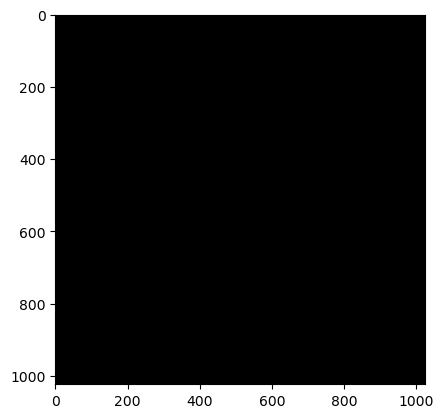

In [7]:
# open test.jpeg as a numpy array
import numpy as np
from PIL import Image


img = Image.open("test.jpeg")
img = np.array(img)


for i in range(0, 1):
    for j in range(0, 1):
        path = trace_path_across_image(img, i, j, {
            "periapsis": 0,
            "ascending_node": 0,
            "inclination": 45 
        })
        plt.imshow(path, cmap="gray")
        plt.show()
    



In [ ]:
from astropy.time import Time
from astropy.coordinates import get_body_barycentric
import astropy.units as u

# Define the J2000 epoch
j2000 = Time('2000-01-01 12:00:00', scale='tt')

# Get the barycentric positions of Earth and the Sun at J2000
earth_barycentric = get_body_barycentric('earth', j2000)
sun_barycentric = get_body_barycentric('sun', j2000)

# Calculate the heliocentric position of Earth by subtracting Sun's position
earth_heliocentric = earth_barycentric - sun_barycentric

# Convert to Astronomical Units (AU)
earth_heliocentric_au = earth_heliocentric.xyz.to(u.au)

# Print the result
print(f"Earth's heliocentric position at J2000 (in AU): {earth_heliocentric_au}")


Earth's heliocentric position at J2000 (in AU): [-0.17713507  0.88742852  0.38474289] AU
